# Steps to be followed

1. Opening dataset
2. Performig cleaning (eliminating , wo lemmatize nahi karna wo BERT apne aap dekhega , LSTM me karna padta bas)
3. Loading Tokenizer , tokenizing the dataset, then converting to TensorDataset
4. Loading Model and making changes in it a per desire
5. Training

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time

## Step 1. Opening Dataset

In [2]:
train_df = pd.read_csv('../input/sentimentdata/train.tsv/train.tsv' , sep='\t')
test_df = pd.read_csv('../input/sentimentdata/test.tsv/test.tsv' , sep = '\t')

In [3]:
train_df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print(train_df.shape)
#print(train_df.info)
print(train_df.columns)
print(train_df.isnull().sum())

(156060, 4)
Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64


<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

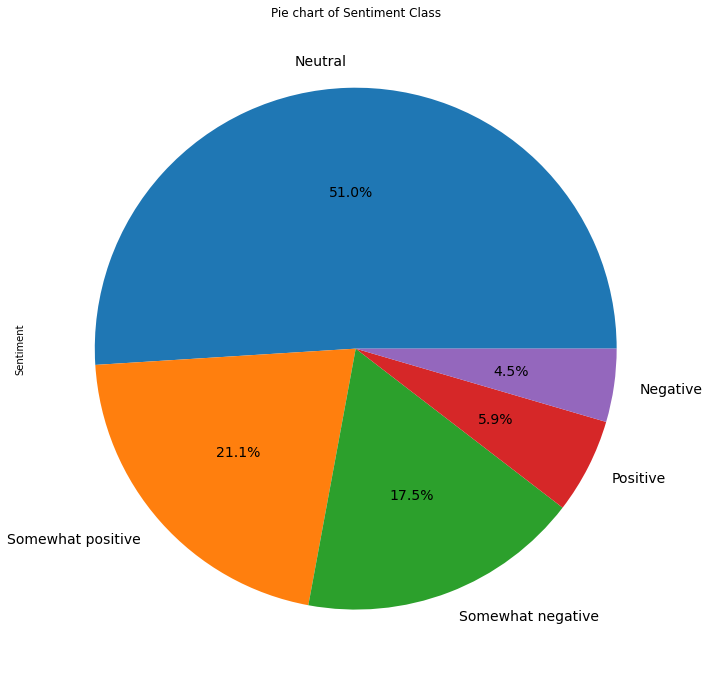

In [5]:
df2=train_df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Text(0.5, 0.98, 'Histogram number of words in reviews')

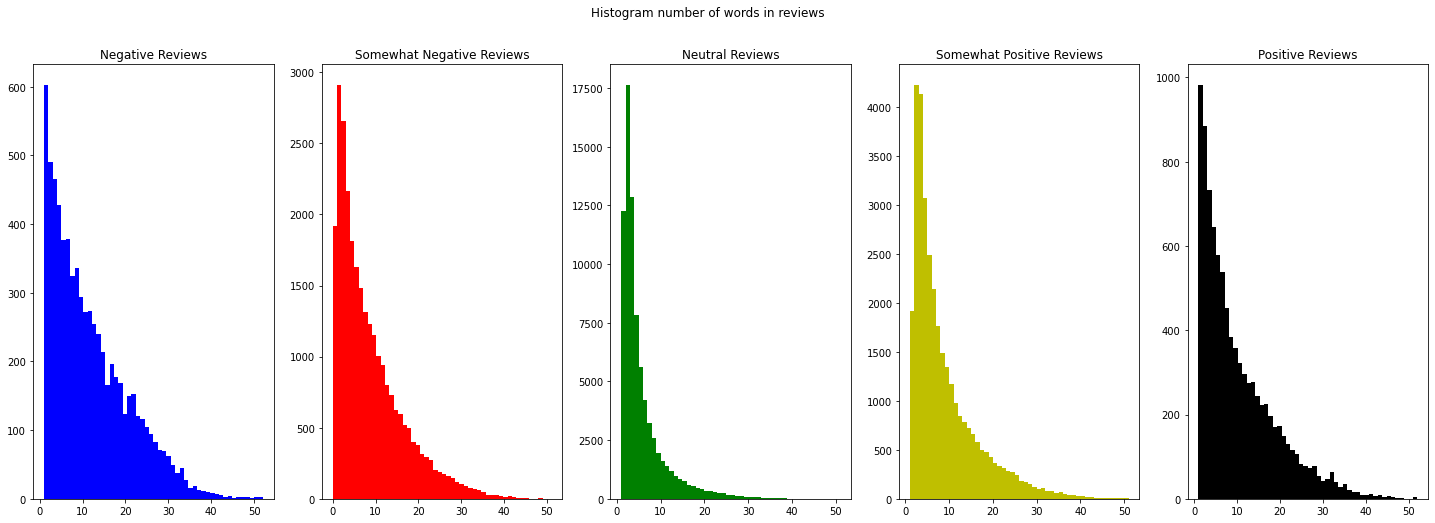

In [6]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))
ax1.hist(train_df[train_df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(train_df[train_df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(train_df[train_df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(train_df[train_df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(train_df[train_df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In [7]:
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


## Step 2. Cleaning


In [8]:
train_df['len'] = train_df['Phrase'].str.split().map(lambda x: len(x))
print(train_df.shape)

train_df = train_df[train_df['len'] <40 ]
print(train_df.shape)

(156060, 5)
(155708, 5)


In [9]:
156060 - 155708

352

In [10]:
train_df['Sentiment'].value_counts()

2    79525
3    32810
1    27195
4     9146
0     7032
Name: Sentiment, dtype: int64

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
X = train_df.drop('Sentiment',axis=1)
y = train_df['Sentiment']
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0) #test size of 10% 

for train_index, test_index in sss.split(X , y):  
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]  
    X_val = X.iloc[test_index]
    y_val = y.iloc[test_index]

In [12]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [13]:
pre_trainer = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pre_trainer)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# The above tokens can be added through the encode_plus method
sample_txt = X_train['Phrase'][0]
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors but you can return tf tensors or np arrays by setting this to tf or np
)
print(encoding.keys())
print(encoding)

dict_keys(['input_ids', 'attention_mask'])
{'input_ids': tensor([[  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,  8050,
          2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,  1110,  1145,
          1363,  1111,  1103,   176,  9900,   117,  1199,  1104,  1134,  5411,
          1821,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


In [15]:
max_len = 35
batch_size = 16

In [16]:
y.values

array([1, 2, 2, ..., 3, 2, 2])

In [17]:
len(X['Phrase'])

155708

In [18]:
y.values[2]

2

## Step 3. Dataset tokenization

In [19]:
class DataGenerator(Dataset):
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        text = str(self.text[idx])
        target = self.targets[idx]
        
        encoding = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length = self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
      #'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [20]:
 encode = tokenizer.encode_plus(
     str(X['Phrase'][2]),
     add_special_tokens=True,
     max_length = max_len,                          
     truncation=True,                          
     padding='max_length',                          
     return_token_type_ids=False,
     return_attention_mask=True,
     return_tensors='pt')

In [21]:
encode

{'input_ids': tensor([[ 101,  138, 1326,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [22]:
def data_loader(X,y , tokenizer, max_len, batch_size):
    ds = DataGenerator(
        text=X['Phrase'].to_numpy(),
        targets=y.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size)

In [23]:
train_data_loader = data_loader(X_train,
                                y_train,
                                tokenizer, max_len, batch_size)
val_data_loader = data_loader(X_val,
                              y_val,
                              tokenizer, max_len, batch_size)

In [24]:
X_train['Phrase'].to_numpy()

array(['have done', 'is and',
       "trimmed Dickens ' wonderfully sprawling soap opera , the better",
       ..., 'all too seriously',
       'the scintillating force of its actors to draw out the menace of its sparse dialogue',
       "Thewlis 's"], dtype=object)

In [25]:
X_train['Phrase'].to_numpy()

array(['have done', 'is and',
       "trimmed Dickens ' wonderfully sprawling soap opera , the better",
       ..., 'all too seriously',
       'the scintillating force of its actors to draw out the menace of its sparse dialogue',
       "Thewlis 's"], dtype=object)

In [26]:
y.to_numpy()

array([1, 2, 2, ..., 3, 2, 2])

In [27]:
# counter = 0
# for data in train_data_loader:
#     print("Enter loop ",counter )
#     print(counter)
#     counter +=1
#     print("safely exiting")
#     print("----------------------")

In [28]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [29]:
data['input_ids']

tensor([[  101,  1138,  1694,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1110,  1105,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 24509, 21677,   112,  7310,  1193, 27541,  8439,  4677,   117,
          1103,  1618,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2157,  1184,  1119,  1144,  1263,  1458,  1106,  1474,   117,
         15034,  1158,  1103,  6176,  1104,  1117,  1319,  3073, 13335, 186

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 35])
torch.Size([16, 35])
torch.Size([16])


In [31]:
# First, a small scale example using our encoder that we created for our sample text
bert = BertModel.from_pretrained(pre_trainer)

# last_hidden_state is a sequence of hidden states of the last layer of the model
# 

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# output = bert(input_ids = data['input_ids'],
#         attention_mask=data['attention_mask'] , return_dict = False)
#output

last_hidden_state, pooled_output = bert(input_ids = data['input_ids'],
        attention_mask=data['attention_mask'] , return_dict = False)
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([16, 35, 768])
torch.Size([16, 768])


## Step 4. Model defining

In [33]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trainer)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, n_classes),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask , return_dict = False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SentimentClassifier(5)
model.to(device)

cuda:0


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [35]:
pred = model.forward(data['input_ids'].to(device) , data['attention_mask'].to(device))

In [36]:
pred.shape

torch.Size([16, 5])

In [37]:
pred

tensor([[0.0604, 0.0702, 0.2469, 0.2234, 0.3991],
        [0.0986, 0.0840, 0.2277, 0.2711, 0.3186],
        [0.0806, 0.1044, 0.2949, 0.1493, 0.3709],
        [0.1921, 0.0885, 0.2970, 0.2031, 0.2193],
        [0.1034, 0.1201, 0.3596, 0.2789, 0.1380],
        [0.0339, 0.1159, 0.2677, 0.0884, 0.4941],
        [0.0466, 0.2045, 0.2446, 0.2664, 0.2379],
        [0.0339, 0.3100, 0.1163, 0.1174, 0.4224],
        [0.0617, 0.2026, 0.1905, 0.1206, 0.4246],
        [0.1002, 0.2489, 0.2101, 0.1551, 0.2857],
        [0.0497, 0.1387, 0.3392, 0.2649, 0.2074],
        [0.0606, 0.1008, 0.3080, 0.1344, 0.3962],
        [0.0756, 0.1375, 0.2709, 0.3039, 0.2121],
        [0.0376, 0.1816, 0.1805, 0.3256, 0.2747],
        [0.0493, 0.1408, 0.3280, 0.0681, 0.4139],
        [0.0484, 0.2006, 0.2656, 0.2506, 0.2347]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [38]:
EPOCHS = 10
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
total_steps = len(train_data_loader) * EPOCHS
loss_fn = nn.CrossEntropyLoss().to(device)

In [39]:
len(train_data_loader)

8759

In [40]:
# for epoch in range(20):
#     start_time = time.time()
    
    
#     # Set model to train configuration
#     model.train()
#     losses = []
#     correct_predictions = 0
#     for d in train_data_loader:
#         input_ids = d["input_ids"].to(device)
#         attention_mask = d["attention_mask"].to(device)
#         targets = d["targets"].to(device)
        
#         outputs = model(input_ids=input_ids,
#                        attention_mask=attention_mask)
        
#         _, preds = torch.max(outputs, dim=1)
#         loss = loss_fn(outputs, targets)
#         correct_predictions += torch.sum(preds == targets)
#         losses.append(loss.item())
#         loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         optimizer.zero_grad()
        
#     elapsed_time = time.time() - start_time    
#     print(f'Epoch {epoch} \t  loss {loss} \t correct predictions {correct_predictions} \t time elapsed {elapsed_time}')

    

In [41]:
for epoch in range(20):
    counter = 0 
    start_time  = time.time()
    
    model.train()
    losses = []
    correct_predictions = 0
    for d in train_data_loader:
        #print("hello")
        #print(counter)
        counter +=1
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)
        ##
        _, preds = torch.max(outputs, dim=1)
        #print(preds)
        loss = loss_fn(outputs, targets)
        #print(loss)
        correct_predictions += torch.sum(preds == targets)
        #print(correct_predictions)
        
        ##
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('Time elapsed ' , time.time() -  start_time)
        ##
    
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch} \t  loss {loss} \t accuracy {correct_predictions / len(X_train) : .4f} \t time elapsed {elapsed_time/60 : .2f} mins')

Epoch 0 	  loss 1.349277138710022 	 accuracy  0.5106 	 time elapsed  11.92 mins
Epoch 1 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.92 mins
Epoch 2 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.90 mins
Epoch 3 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.89 mins
Epoch 4 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.90 mins
Epoch 5 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.91 mins
Epoch 6 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.93 mins
Epoch 7 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.98 mins
Epoch 8 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.91 mins
Epoch 9 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.91 mins
Epoch 10 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.90 mins
Epoch 11 	  loss 1.349277138710022 	 accuracy  0.5107 	 time elapsed  11.93 mins
Epoch 12 	  loss 1.349277138710022 	 a

In [42]:
#len(X_train)/len(train_data_loader)

In [43]:
#len(X_val)

In [44]:
#print(f'Epoch {epoch} \t  loss {loss} \t accuracy {correct_predictions / len(X_val) : .4f} \t time elapsed {elapsed_time/60 : .2f} mins')